# 사례 연구 1: 출현-전용 데이터를 이용한 팔색조(Pitta nympha) 서식지 적합성 및 예측 분포 모델링

In [1]:
import ee
import geemap
import geemap.colormaps as cm

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Earth Engine 인증
# ee.Authenticate()

# Earth Engine 초기화
ee.Initialize()

In [3]:
# geemap 빈 지도 객체 생성
Map = geemap.Map()

## 1. 종 출현 데이터 추가

In [4]:
# 입력 파일 경로
input_gpkg_file = 'pitta_nympha_data.gpkg'

# GeoPackage 파일 로드
gdf = gpd.read_file(input_gpkg_file)[["species", "year", "month", "geometry"]]

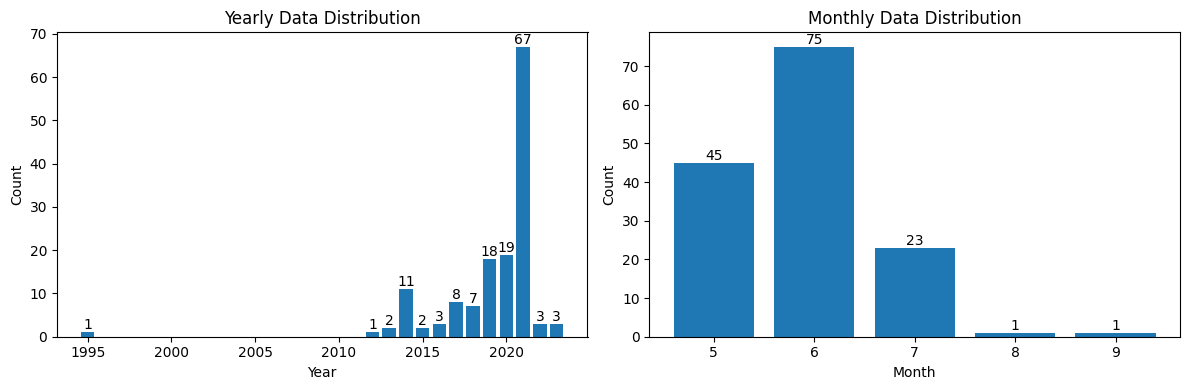

In [5]:
def plot_data_distribution(gdf):
    
    # 연도별 데이터 분포 그래프 (왼쪽)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    year_counts = gdf['year'].value_counts().sort_index()
    plt.bar(year_counts.index, year_counts.values)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Yearly Data Distribution')
    
    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(year_counts.values):
        plt.text(year_counts.index[i], count, str(count), ha='center', va='bottom')
    
    # 월별 데이터 분포 그래프 (오른쪽)
    plt.subplot(1, 2, 2)
    month_counts = gdf['month'].value_counts().sort_index()
    plt.bar(month_counts.index, month_counts.values)
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.title('Monthly Data Distribution')
    
    # 막대 그래프 안에 데이터 개수 표시
    for i, count in enumerate(month_counts.values):
        plt.text(month_counts.index[i], count, str(count), ha='center', va='bottom')

    # x 축의 눈금을 정수 형식으로 설정
    plt.xticks(month_counts.index, map(int, month_counts.index))
    
    # 그래프 출력
    plt.tight_layout()
    plt.savefig('data_distribution_plot.png')
    plt.show()

plot_data_distribution(gdf)

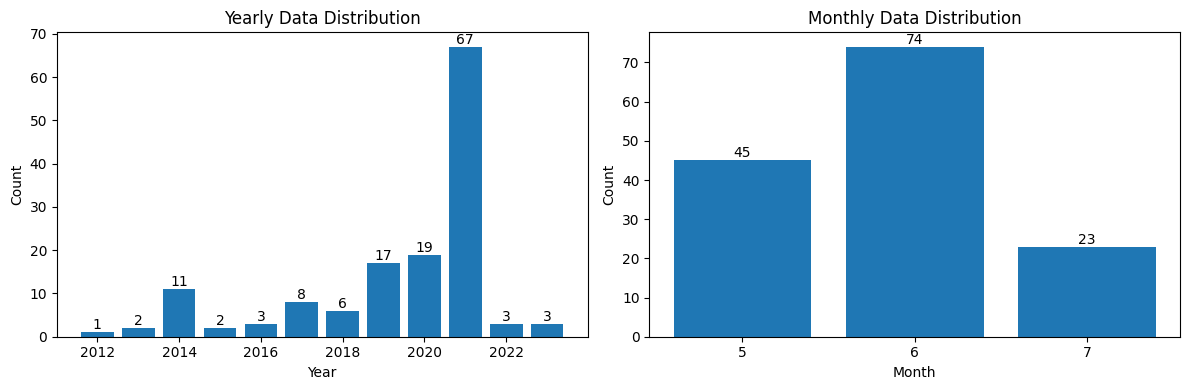

In [6]:
# 연도와 월 기반으로 필터링
filtered_gdf = gdf[
    (~gdf['year'].eq(1995)) &
    (~gdf['month'].between(8, 9))
]

plot_data_distribution(filtered_gdf)

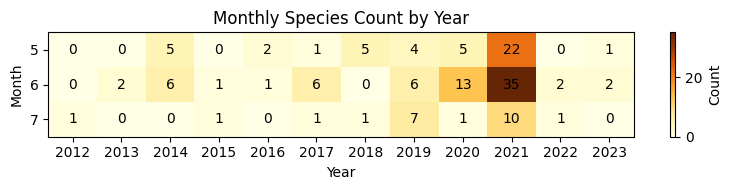

year   2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  2023
month                                                                        
5         0     0     5     0     2     1     5     4     5    22     0     1
6         0     2     6     1     1     6     0     6    13    35     2     2
7         1     0     0     1     0     1     1     7     1    10     1     0


In [7]:
def plot_heatmap_from_gdf(gdf):
    # 필요한 통계 계산
    statistics = gdf.groupby(["month", "year"]).size().unstack(fill_value=0)
    
    # 히트맵으로 통계 시각화
    plt.figure(figsize=(8, 2))
    heatmap = plt.imshow(statistics.values, cmap="YlOrBr", origin="upper", aspect="auto")

    # 각 픽셀 위에 수치 표시
    for i in range(len(statistics.index)):
        for j in range(len(statistics.columns)):
            plt.text(j, i, statistics.values[i, j], ha="center", va="center", color="black")

    plt.colorbar(heatmap, label="Count")
    plt.title("Monthly Species Count by Year")
    plt.xlabel("Year")
    plt.ylabel("Month")
    plt.xticks(range(len(statistics.columns)), statistics.columns)
    plt.yticks(range(len(statistics.index)), statistics.index)
    plt.tight_layout()
    plt.savefig('heatmap_plot.png')
    plt.show()

# 히트맵 그래프 출력 함수 호출
plot_heatmap_from_gdf(filtered_gdf)

# 통계 테이블 출력
print(filtered_gdf.groupby(["month", "year"]).size().unstack(fill_value=0))

In [8]:
# 출력 파일 경로
output_shapefile = 'pitta_nympha_data.shp'

# shapefile로 저장
filtered_gdf.to_file(output_shapefile)

# 출현(presence) 원시 데이터 추가
data_raw = geemap.shp_to_ee(output_shapefile)

In [9]:
# 작업할 공간 해상도 설정(m)
GrainSize = 1000

def remove_duplicates(data, GrainSize):
    # 선택한 공간 해상도(1km)에서 픽셀 당 출현 기록 하나만 무작위 선택
    random_raster = ee.Image.random().reproject('EPSG:4326', None, GrainSize)
    rand_point_vals = random_raster.sampleRegions(collection=ee.FeatureCollection(data), scale=10, geometries=True)
    return rand_point_vals.distinct('random')

Data = remove_duplicates(data_raw, GrainSize)

In [10]:
print('Original data size:', data_raw.size().getInfo())
print('Final data size:', Data.size().getInfo())

Original data size: 142
Final data size: 95


In [11]:
vis_params = {'color': 'blue'}
Map.addLayer(data_raw, vis_params, 'Original data')
Map.centerObject(data_raw.geometry(), 7)

vis_params = {'color': 'red'}
Map.addLayer(Data, vis_params, 'Final data')
Map.centerObject(Data.geometry(), 7)

# Map

## 2. 관심 영역 정의

In [12]:
# AOI 정의
AOI = Data.geometry().bounds().buffer(distance=50000, maxError=1000)

# 연구지역 경계를 지도에 추가
outline = ee.Image().byte().paint(featureCollection=AOI, color=1, width=3)
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 3. 예측 변수 추가

In [13]:
# WorldClim BIO Variables V1(1㎞): 총 19개 기후 변수
BIO = ee.Image("WORLDCLIM/V1/BIO")

# NASA SRTM Digital Elevation 30m: 디지털 고도 데이터
Terrain = ee.Algorithms.Terrain(ee.Image("USGS/SRTMGL1_003"))

# MOD44B.006 Terra MODIS Vegetation Continuous Fields Yearly Global 250m
# 수목 피복 확률(percent tree cover): 2003~2020년 사이 중간값
MODIS = ee.ImageCollection("MODIS/006/MOD44B")
MedianPTC = MODIS.filterDate('2003-01-01', '2020-12-31').select(['Percent_Tree_Cover'], ['PTC']).median()

In [14]:
# 밴드들을 단일 다중-밴드 이미지로 결합
predictors = BIO.addBands(Terrain).addBands(MedianPTC)

# 예측 변수 이미지에서 해양 픽셀 마스킹
watermask =  Terrain.select('elevation').gt(0) # 수역 마스크 생성
predictors = predictors.updateMask(watermask).clip(AOI) # 해양 픽셀 마스킹 & 관심 영역 클리핑

In [15]:
# 5000개 임의 지점에서 다중-밴드 예측 이미지 간 공변량 값 추출
DataCor = predictors.sample(scale=GrainSize, numPixels=5000, geometries=True) # 5000개 임의 지점 생성
PixelVals = predictors.sampleRegions(collection=DataCor, scale=GrainSize, tileScale=16) # 공변량 값 추출

In [16]:
# 공변량 값 ee를 df로 변환
PixelVals_df = geemap.ee_to_pandas(PixelVals)
PixelVals_df.head()

elevation  bio08  bio19  bio09  slope  bio10  hillshade  aspect  bio06  \
0         31    247    112     27      0    247        181     296    -27   
1        329    216     62    -57      6    222        188     203   -146   
2        586    210     95    -51     10    210        190     198   -127   
3        143    226     65    -33      3    232        173      64   -109   
4        367    217     50    -64      4    217        191     251   -141   

   bio17  ...  bio05  bio16  bio02  bio13  bio03  bio14  bio11   PTC  bio01  \
0    112  ...    304    563     89    218     26     33     27   7.0    139   
1     62  ...    281    836    119    401     27     17    -57  51.0     90   
2     95  ...    269    785    117    340     29     30    -51  63.0     85   
3     65  ...    287    897    106    439     26     18    -33  19.5    106   
4     50  ...    276    665    108    323     25     14    -64  28.0     84   

   bio12  
0   1162  
1   1289  
2   1400  
3   1403  
4   1067  

[5 rows x 24 columns]

In [17]:
columns = PixelVals_df.columns
columns

Index(['elevation', 'bio08', 'bio19', 'bio09', 'slope', 'bio10', 'hillshade',
       'aspect', 'bio06', 'bio17', 'bio07', 'bio18', 'bio04', 'bio15', 'bio05',
       'bio16', 'bio02', 'bio13', 'bio03', 'bio14', 'bio11', 'PTC', 'bio01',
       'bio12'],
      dtype='object')

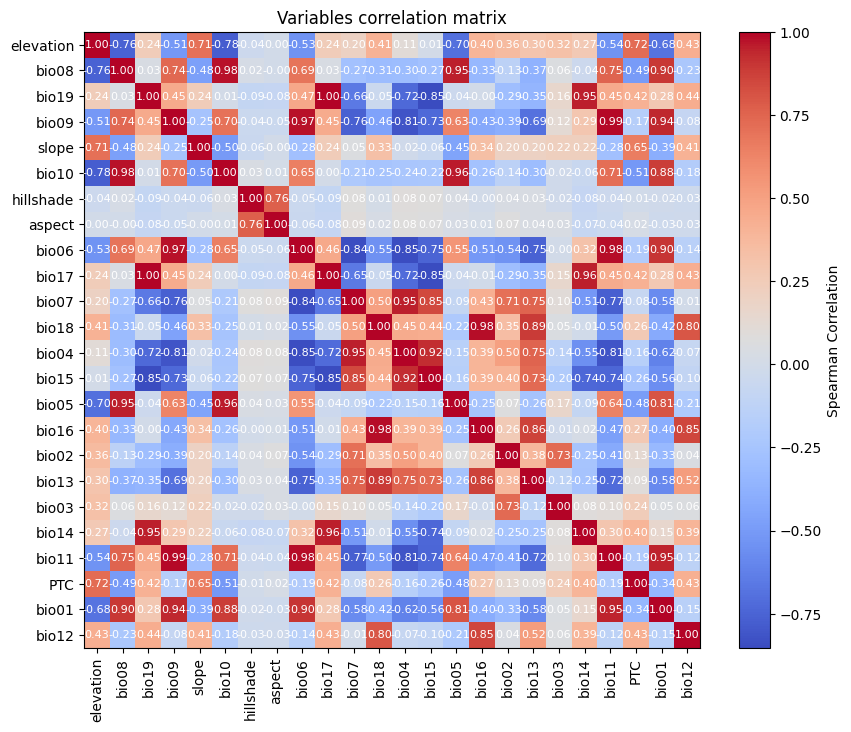

In [18]:
def plot_correlation_heatmap(dataframe, h_size=10):
    # 스피어만 상관계수 계산
    correlation_matrix = dataframe.corr(method="spearman")

    # 히트맵 그리기
    plt.figure(figsize=(h_size, h_size-2))
    plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')

    # 히트맵에 수치 표시
    for i in range(correlation_matrix.shape[0]):
        for j in range(correlation_matrix.shape[1]):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}",
                     ha='center', va='center', color='white', fontsize=8)  # fontsize 조정

    columns = dataframe.columns.tolist()
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    plt.title("Variables correlation matrix")
    plt.colorbar(label="Spearman Correlation")
    # plt.savefig('correlation_heatmap_plot.png')
    plt.show()

# 변수 상관행렬 히트맵
plot_correlation_heatmap(PixelVals_df)

In [19]:
def filter_variables_by_vif(dataframe, threshold=10):
    original_columns = dataframe.columns.tolist()
    remaining_columns = original_columns[:]
    
    while True:
        vif_data = dataframe[remaining_columns]
        vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
        
        max_vif_index = vif_values.index(max(vif_values))
        max_vif = max(vif_values)
        
        if max_vif < threshold:
            break
        
        print(f"Removing '{remaining_columns[max_vif_index]}' with VIF {max_vif:.2f}")
        
        del remaining_columns[max_vif_index]
    
    filtered_data = dataframe[remaining_columns]
    return filtered_data

# VIF(Variance Inflation Factor, 분산 팽창 요인)로 필터링 수행
filtered_PixelVals_df = filter_variables_by_vif(PixelVals_df)
bands = filtered_PixelVals_df.columns.tolist()
predictors = predictors.select(bands)
print('Bands:', bands)

Removing 'bio06' with VIF inf
Removing 'bio04' with VIF 213143.75
Removing 'bio10' with VIF 68437.04
Removing 'bio17' with VIF 48555.55
Removing 'bio05' with VIF 32374.85
Removing 'bio07' with VIF 22348.86
Removing 'bio01' with VIF 9725.41
Removing 'bio16' with VIF 3785.62
Removing 'bio03' with VIF 2515.02
Removing 'bio18' with VIF 1791.83
Removing 'bio08' with VIF 1383.23
Removing 'bio12' with VIF 618.77
Removing 'bio19' with VIF 488.40
Removing 'bio15' with VIF 340.60
Removing 'hillshade' with VIF 120.15
Removing 'bio13' with VIF 49.94
Removing 'bio11' with VIF 35.68
Removing 'bio02' with VIF 15.55
Bands: ['elevation', 'bio09', 'slope', 'aspect', 'bio14', 'PTC']


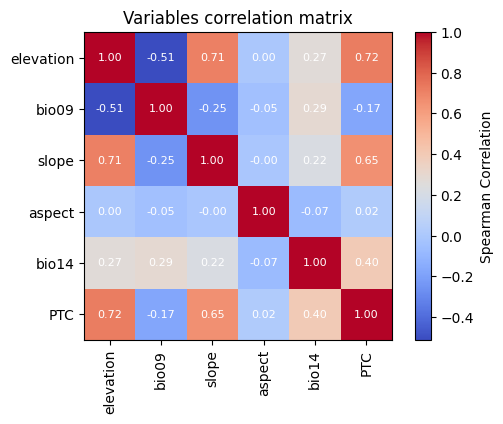

In [20]:
# 변수 상관행렬 히트맵
plot_correlation_heatmap(filtered_PixelVals_df, h_size=6)

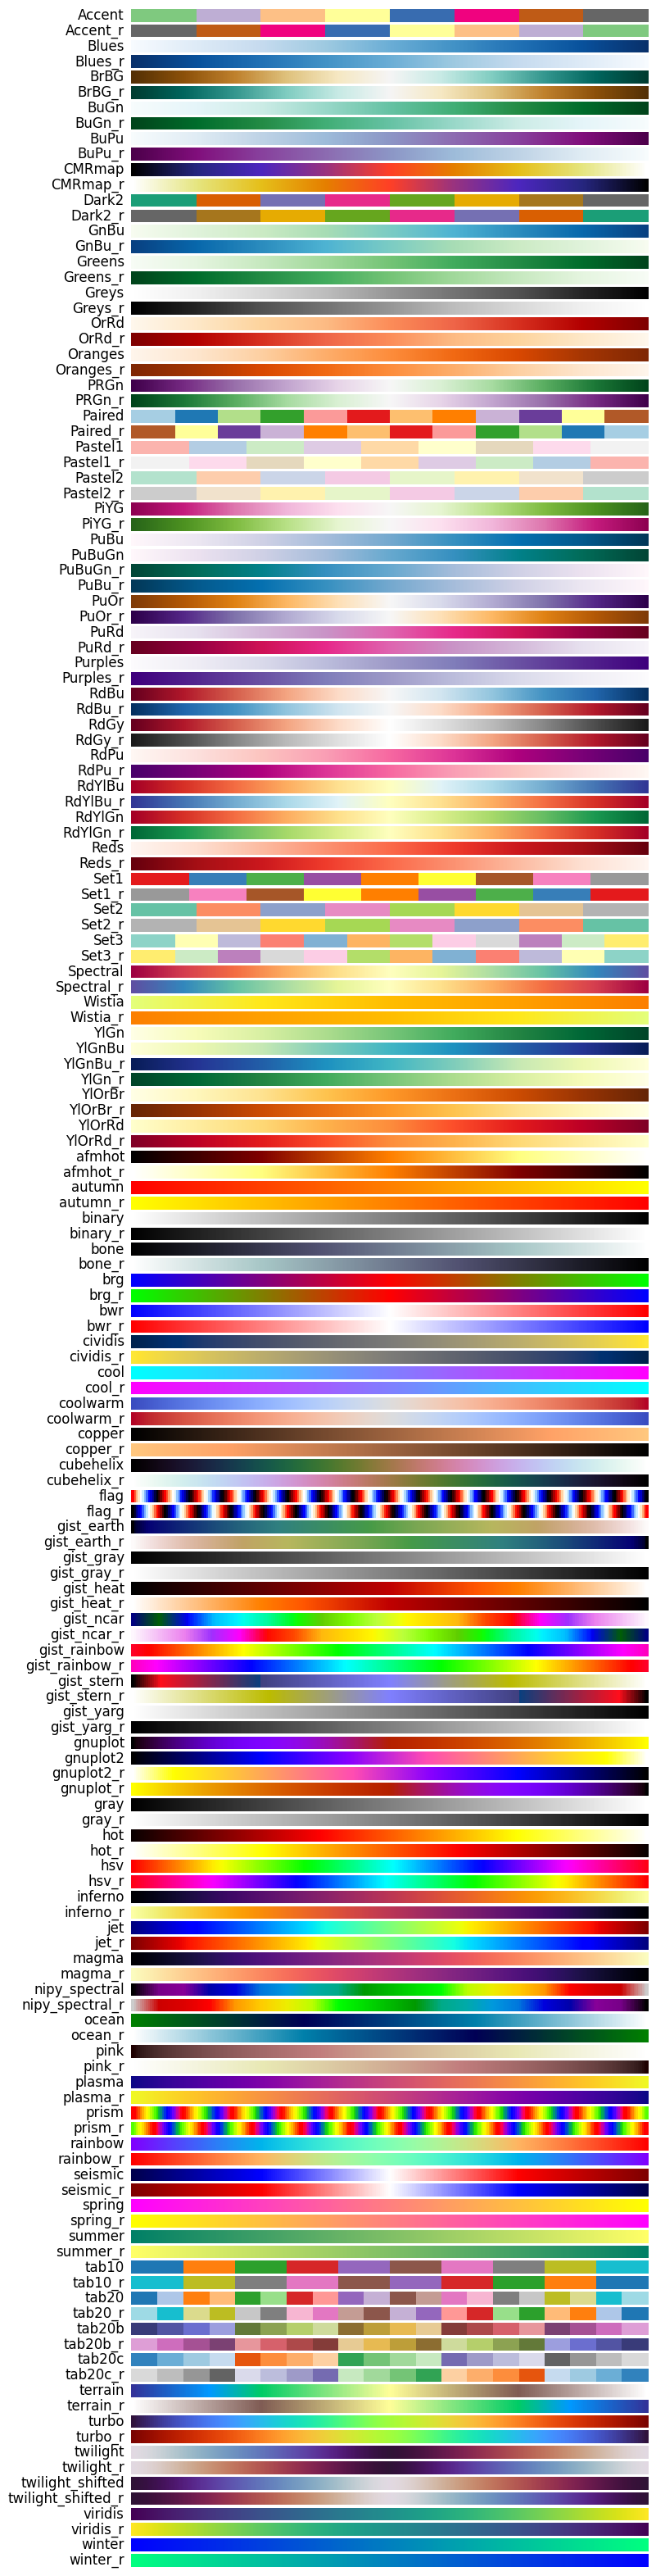

In [21]:
cm.plot_colormaps(width=8.0, height=0.2)

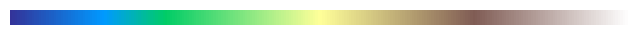

In [22]:
cm.plot_colormap('terrain', width=8.0, height=0.2, orientation='horizontal')

In [23]:
# elevation
Map = geemap.Map()
vis_params = {'bands':['elevation'], 'min': 0, 'max': 1800, 'palette': cm.palettes.terrain}
Map.addLayer(predictors, vis_params, 'elevation')
Map.add_colorbar(vis_params, label="Elevation (m)", orientation="vertical", layer_name="elevation")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [24]:
# bio09 최소값 & 최대값
min_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
max_val = predictors.select("bio09").multiply(0.1).reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()
print("Minimum Value:", min_val)
print("Maximum Value:", max_val)

Minimum Value: {'bio09': -10.9}
Maximum Value: {'bio09': 13.5}


In [25]:
# bio09
Map = geemap.Map()
vis_params = {'min': -11, 'max': 14, 'palette': cm.palettes.hot}
Map.addLayer(predictors.select("bio09").multiply(0.1), vis_params, 'bio09')
Map.add_colorbar(vis_params, label="Mean temperature of driest quarter (℃)", orientation="vertical", layer_name="bio09")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [26]:
# slope
Map = geemap.Map()
vis_params = {'bands':['slope'], 'min': 0, 'max': 25, 'palette': cm.palettes.RdYlGn_r}
Map.addLayer(predictors, vis_params, 'slope')
Map.add_colorbar(vis_params, label="Slope", orientation="vertical", layer_name="slope")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
# aspect
Map = geemap.Map()
vis_params = {'bands':['aspect'], 'min': 0, 'max': 360, 'palette': cm.palettes.rainbow}
Map.addLayer(predictors, vis_params, 'aspect')
Map.add_colorbar(vis_params, label="Aspect", orientation="vertical", layer_name="aspect")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [28]:
# bio14 최소값 & 최대값
# min_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.min(), scale=1000).getInfo()
# max_val = predictors.select("bio14").reduceRegion(reducer=ee.Reducer.max(), scale=1000).getInfo()
# print("Minimum Value:", min_val)
# print("Maximum Value:", max_val)

# bio14
Map = geemap.Map()
vis_params = {'bands':['bio14'], 'min': 0, 'max': 90, 'palette': cm.palettes.Blues}
Map.addLayer(predictors, vis_params, 'bio14')
Map.add_colorbar(vis_params, label="Precipitation of driest month (mm)", orientation="vertical", layer_name="bio14")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [29]:
# PTC
Map = geemap.Map()
vis_params = {'bands':['PTC'], 'min': 1, 'max': 100, 'palette': ['bbe029', '0a9501', '074b03']}
Map.addLayer(predictors, vis_params, 'PTC')
Map.add_colorbar(vis_params, label="Percent Tree Cover (%)", orientation="vertical", layer_name="PTC")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 4. 임의-비출현 데이터 생성

### 4.1. 전체 관심 영역에서 무작위 임의-비출현 데이터 생성

In [30]:
# AreaForPA
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()
AreaForPA = presence_mask.updateMask(watermask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

### 4.2. 공간 제약된 임의-비출현 데이터 생성(출현 데이터 버퍼)

In [31]:
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()
presence_buffer_mask = Data.geometry().buffer(distance=50000, maxError=1000)
AreaForPA = presence_mask.clip(presence_buffer_mask).updateMask(watermask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

### 4.3. 환경적 임의-비출현 데이터 생성(Enviromental profiling)

In [32]:
presence_mask = Data.reduceToImage(
    properties=['random'],
    reducer=ee.Reducer.first()
).reproject('EPSG:4326', None, ee.Number(GrainSize)).mask().neq(1).selfMask()

# 출현 데이터의 임의 부분집합에서 예측 변수 값 추출
PixelVals = predictors.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(100),
    properties=[],
    tileScale=16,
    scale=GrainSize
)

# k-평균 클러스터링 훈련
clusterer = ee.Clusterer.wekaKMeans(
    nClusters=2,
    distanceFunction="Euclidean"
).train(PixelVals)

# 훈련된 클러스터러를 사용하여 픽셀 할당
Clresult = predictors.cluster(clusterer)

# 출현 데이터와 유사한 클러스터 ID 획득
clustID = Clresult.sampleRegions(
    collection=Data.randomColumn().sort('random').limit(200),
    properties=[],
    tileScale=16,
    scale=GrainSize
)
# 반대 클러스터 사용, 임의-비출현 허용 영역 정의
clustID = ee.FeatureCollection(clustID).reduceColumns(ee.Reducer.mode(),['cluster'])
clustID = ee.Number(clustID.get('mode')).subtract(1).abs()
cl_mask = Clresult.select(['cluster']).eq(clustID)
AreaForPA = presence_mask.updateMask(cl_mask).clip(AOI)

Map = geemap.Map()
Map.addLayer(AreaForPA, {'palette': 'black'},'AreaForPA')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [33]:
# Grid for spatial block cross-validation 생성
def makeGrid(geometry, scale):
    # 경도 & 위도 도 단위 이미지 생성
    lonLat = ee.Image.pixelLonLat()
    # 경도 & 위도 이미지 정수화
    lonGrid = lonLat.select('longitude').multiply(100000).toInt()
    latGrid = lonLat.select('latitude').multiply(100000).toInt()
    
    return lonGrid.multiply(latGrid).reduceToVectors(
        # geometry경계 포함 격자 생성 
        geometry = geometry.buffer(distance=20000, maxError=1000),
        scale = scale,
        geometryType = 'polygon'
    )

Scale = 50000
grid = makeGrid(AOI, Scale)
Grid = watermask.reduceRegions(
    collection=grid,
    reducer=ee.Reducer.mean()).filter(ee.Filter.neq('mean', None))

Map = geemap.Map()
Map.addLayer(Grid, {}, "Grid for spatial block cross validation")
Map.addLayer(outline, {'palette': 'FF0000'}, "Study Area")
Map.centerObject(Data.geometry(), 6)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

## 5. SDM 모델 적합

In [34]:
def SDM(x):
    Seed = ee.Number(x)

    # 훈련 및 검증을 위한 무작위 블록 분할
    GRID = ee.FeatureCollection(Grid).randomColumn(seed=Seed).sort('random')
    TrainingGrid = GRID.filter(ee.Filter.lt('random', split)) # 훈련용 격자
    TestingGrid = GRID.filter(ee.Filter.gte('random', split)) # 시험용 격자
    
    # 출현 지점
    PresencePoints = ee.FeatureCollection(Data)
    PresencePoints = PresencePoints.map(lambda feature: feature.set('PresAbs', 1))
    TrPresencePoints = PresencePoints.filter(ee.Filter.bounds(TrainingGrid)) # 훈련용 출현 지점
    TePresencePoints = PresencePoints.filter(ee.Filter.bounds(TestingGrid)) # 검증용 출현 지점
    
    # 임의-비출현 지점
    TrPseudoAbsPoints = AreaForPA.sample(region=TrainingGrid,
                                         scale=GrainSize,
                                         numPixels=TrPresencePoints.size().add(300),
                                         seed=Seed,
                                         geometries=True)
    # 훈련용 출현 지점과 동일한 수의 임의-비출현 지점
    TrPseudoAbsPoints = TrPseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TrPresencePoints.size()))
    TrPseudoAbsPoints = TrPseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))
    
    TePseudoAbsPoints = AreaForPA.sample(region=TestingGrid,
                                         scale=GrainSize,
                                         numPixels=TePresencePoints.size().add(100),
                                         seed=Seed,
                                         geometries=True)
    # 검증용 출현 지점과 동일한 수의 임의-비출현 지점
    TePseudoAbsPoints = TePseudoAbsPoints.randomColumn().sort('random').limit(ee.Number(TePresencePoints.size()))
    TePseudoAbsPoints = TePseudoAbsPoints.map(lambda feature: feature.set('PresAbs', 0))

    # 훈련 및 임의-비출현 지점 병합
    trainingPartition = TrPresencePoints.merge(TrPseudoAbsPoints) # 훈련용 지점
    testingPartition = TePresencePoints.merge(TePseudoAbsPoints) # 시험용 지점

    # 훈련용 지점에서 예측 변수 이미지의 공변량 값 추출 
    trainPixelVals = predictors.sampleRegions(collection=trainingPartition,
                                              properties=['PresAbs'],
                                              scale=GrainSize,
                                              tileScale=16,
                                              geometries=True)

    # 랜덤 포레스트 분류기(Random Forest classifier)
    Classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=500, # 생성할 결정 트리의 수
        variablesPerSplit=None, # 분할당 변수의 수. 기본값: 변수 수의 제곱근 사용
        minLeafPopulation=10, # 훈련 셋에 최소한 이 개수의 지점이 포함된 노드만 생성
        bagFraction=0.5, # 트리당 백에 대한 입력 비율
        maxNodes=None, # 각 트리의 최대 리프 노드 수. 기본값: 제한 없음
        seed=Seed # 무작위화 시드
    )
    
    # 출현 확률(Presence probability)
    ClassifierPr = Classifier.setOutputMode('PROBABILITY').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgPr = predictors.select(bands).classify(ClassifierPr)
    
    # 이진 출현/비출현 지도(Binary presence/absence map)
    ClassifierBin = Classifier.setOutputMode('CLASSIFICATION').train(trainPixelVals, 'PresAbs', bands)
    ClassifiedImgBin = predictors.select(bands).classify(ClassifierBin)
   
    return ee.List([ClassifiedImgPr, ClassifiedImgBin, trainingPartition, testingPartition])

In [35]:
split = 0.70  # 공간 블록은 모델 적합의 경우 70%, 모델 검증의 경우 30%로 각각 분할
numiter = 10 # 반복 횟수

runif = lambda length: [random.randint(1, 1000) for _ in range(length)] # 시드
results = ee.List(runif(numiter)).map(SDM).flatten()

# 6. SDM 모델 예측

In [36]:
# 서식지 적합성 지도(Habitat suitability map)
images = ee.List.sequence(0, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
ModelAverage = ee.ImageCollection.fromImages(images).mean()

Map = geemap.Map()
vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['#440154', '#482677', '#404788', '#33638D', '#287D8E',
          '#1F968B', '#29AF7F', '#55C667', '#95D840', '#DCE319']}
Map = geemap.Map()
Map.addLayer(ModelAverage, vis_params, 'Habitat suitability')
Map.add_colorbar(vis_params, label="Habitat suitability", orientation="horizontal", layer_name="Habitat suitability")
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…

In [37]:
# 잠재 분포 지도(Potential distribution map)
images2 = ee.List.sequence(1, ee.Number(numiter).multiply(4).subtract(1), 4).map(lambda x: results.get(x))
DistributionMap = ee.ImageCollection.fromImages(images2).mode()

vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green']}
Map = geemap.Map()
Map.addLayer(DistributionMap, vis_params, 'Potential distribution')
Map.addLayer(Data, {'color':'red'}, 'Presence')
Map.add_colorbar(vis_params, label="Potential distribution", discrete=True, orientation="horizontal", layer_name="Potential distribution")
Map.centerObject(Data.geometry(), 7)
Map

Map(center=[35.50240858290351, 126.88242571246926], controls=(WidgetControl(options=['position', 'transparent_…